In [1]:
import pandas
from itertools import product
import sys, argparse, os
import numpy as np
from math import log, ceil
from scipy.stats import multinomial, chi2
from math import factorial
import re
import os

In [2]:
from Bio import Phylo
from io import BytesIO     # for handling byte strings
from io import StringIO    # for handling unicode strings

## Define Bandelt_Node Class

In [3]:
class Bandelt_Node:
    def __init__(self, data):
        self.parent = None
        self.left = None
        self.right = None
        self.data = data
        
    def find_node(self, val):
        if self.data == val:
            return self
        else:
            if (self.left == None) and (self.right == None):
                return None
            if self.left != None:
                find_left = self.left.find_node(val)
                if find_left != None:
                    return find_left
            if self.right != None:
                find_right = self.right.find_node(val)
                if find_right != None:
                    return find_right
            return None
        
    def print_details(self):
        parent_data = self.parent.data if (self.parent != None) else self.parent
        left_data = self.left.data if (self.left != None) else self.left
        right_data = self.right.data if (self.right != None) else self.right
        print("Current Value: ", self.data, "; Parent: ", parent_data, "; left: ", left_data, "; right: ", right_data)
        
    def print_subtree(self, indent_num = 1):
        if indent_num == 1:
            print(self.data)
        if self.left != None:
            print('___'*indent_num, self.left.data)
            self.left.print_subtree(indent_num + 1)
        if self.right != None:
            print('___'*indent_num, self.right.data)
            self.right.print_subtree(indent_num + 1)
            
    def compare_subtree(self, compared_root_node):
        if self.data != compared_root_node.data:
#             print("Current number is not equal!")
            return False
        
        self_left_data = self.left.data if (self.left != None) else None
        self_right_data = self.right.data if (self.right != None) else None

        compared_root_node_left_data = compared_root_node.left.data if (compared_root_node.left != None) else None
        compared_root_node_right_data = compared_root_node.right.data if (compared_root_node.right != None) else None

        
        if (self_left_data in [compared_root_node_left_data, compared_root_node_right_data]) and (self_right_data in [compared_root_node_left_data, compared_root_node_right_data]):
#             print("Children are same !!")
            if (self_left_data == compared_root_node_left_data):
#                 print("Order are same !!")
                if self.left != None:
                    compare_ans_left = self.left.compare_subtree(compared_root_node.left)
                    if not compare_ans_left:
                        return False
                if self.right != None:
                    compare_ans_right = self.right.compare_subtree(compared_root_node.right)
                    if not compare_ans_right:
                        return False
                
            elif (self_left_data == compared_root_node_right_data):
#                 print("Order are not same !!")
                if self.left != None:
                    compare_ans_left = self.left.compare_subtree(compared_root_node.right)
                    if not compare_ans_left:
                        return False
                if self.right != None:
                    compare_ans_right = self.right.compare_subtree(compared_root_node.left)
                    if not compare_ans_right:
                        return False
        else:
#             print("Children are not same !!")
            return False
        return True

# Implement Encoding Method

In [4]:
def create_Bandelt_Tree(clade, parent_node):
    for idx in range(len(clade)):
        if idx == 0:
            if clade[idx].is_terminal():
                children_node = Bandelt_Node(int(clade[idx].name))
                # Parent add 
                parent_node.left = children_node
                children_node.parent = parent_node
#                 print(clade[idx].name)
            else:
                children_node = Bandelt_Node(int(clade[idx].confidence))
                parent_node.left = children_node
                children_node.parent = parent_node
#                 print(clade[idx].confidence)
        if idx == 1:  
            if clade[idx].is_terminal():
                children_node = Bandelt_Node(int(clade[idx].name))
                # Parent add 
                parent_node.right = children_node
                children_node.parent = parent_node
#                 print(clade[idx].name)
            else:
                children_node = Bandelt_Node(int(clade[idx].confidence))
                parent_node.right = children_node
                children_node.parent = parent_node
#                 print(clade[idx].confidence)
        create_Bandelt_Tree(clade[idx], children_node)

In [5]:
def find_Bandelt_encode(target_node, val):
    visited_nodes = []
    queue = []
    visited_nodes.append(target_node.data)
    queue.append(target_node)
    encode_num = None
    while queue:
        current_node = queue.pop(0)
        if current_node != None:
#             print ("**** current_node: ", current_node.data) 
            if current_node.data != '*' and abs(int(current_node.data)) < abs(int(val)):
                encode_num = current_node.data
        if current_node.left != None:
            if current_node.left.data not in visited_nodes:
                visited_nodes.append(current_node.left.data)
                queue.append(current_node.left)
                
        if current_node.right != None:
            if current_node.right.data not in visited_nodes:
                visited_nodes.append(current_node.right.data)
                queue.append(current_node.right)   
        if encode_num != None:
            break
    return encode_num

In [6]:
def Bandelt_Encode(tree_string):
    handle = StringIO(tree_string)
    tree = Phylo.read(handle, "newick")
    BANDELT_NUM = tree.count_terminals() - 1
    root_node = Bandelt_Node(sys.maxsize)
    inner_root = Bandelt_Node(int(tree.root.confidence))
    root_node.left = inner_root
    inner_root.parent = root_node
    create_Bandelt_Tree(tree.root, inner_root)
    encode_num_list = []
    for i in range(0, BANDELT_NUM):
        target_node_val = -(i+1)
        found_node = root_node.find_node(target_node_val)
#         print(found_node.print_details(), '\n')
        encode_num = find_Bandelt_encode(found_node, target_node_val)
        encode_num_list.append(encode_num)
    return (root_node, encode_num_list)

### First Tree Encode Example

#### Get Bandelt Encoding Result

In [7]:
first_tree_encode, first_Bandelt_encode = Bandelt_Encode("(1,(2,(((6,4)-6,5)-5,(0,((7,3)-7,(8,9)-9)-8)-3)-4)-2)-1;")

#### Check Tree Topology

In [8]:
first_Bandelt_encode

[0, 0, 0, -3, 4, 4, 3, -7, 8]

In [9]:
first_tree_encode.print_subtree()

9223372036854775807
___ -1
______ 1
______ -2
_________ 2
_________ -4
____________ -5
_______________ -6
__________________ 6
__________________ 4
_______________ 5
____________ -3
_______________ 0
_______________ -8
__________________ -7
_____________________ 7
_____________________ 3
__________________ -9
_____________________ 8
_____________________ 9


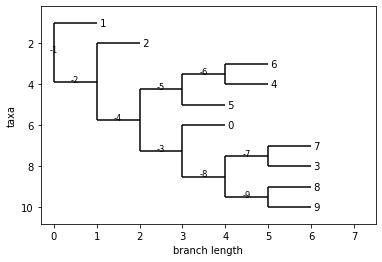

In [10]:
treedata = "(1,(2,(((6,4)-6,5)-5,(0,((7,3)-7,(8,9)-9)-8)-3)-4)-2)-1;"
handle = StringIO(treedata)
tree = Phylo.read(handle, "newick")
# tree.ladderize()   # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

In [11]:
print(tree)

Tree(rooted=False, weight=1.0)
    Clade(confidence=-1.0)
        Clade(name='1')
        Clade(confidence=-2.0)
            Clade(name='2')
            Clade(confidence=-4.0)
                Clade(confidence=-5.0)
                    Clade(confidence=-6.0)
                        Clade(name='6')
                        Clade(name='4')
                    Clade(name='5')
                Clade(confidence=-3.0)
                    Clade(name='0')
                    Clade(confidence=-8.0)
                        Clade(confidence=-7.0)
                            Clade(name='7')
                            Clade(name='3')
                        Clade(confidence=-9.0)
                            Clade(name='8')
                            Clade(name='9')


### Second Tree Encode Example

#### Get Bandelt Encoding Result

In [12]:
second_tree_encode, second_Bandelt_encode  = Bandelt_Encode("(((0,4)-4,(1,(5,2)-5)-2)-1,3)-3;")

#### Check Tree Topology

In [13]:
second_Bandelt_encode

[0, 1, -1, 0, 2]

In [14]:
second_tree_encode.print_subtree()

9223372036854775807
___ -3
______ -1
_________ -4
____________ 0
____________ 4
_________ -2
____________ 1
____________ -5
_______________ 5
_______________ 2
______ 3


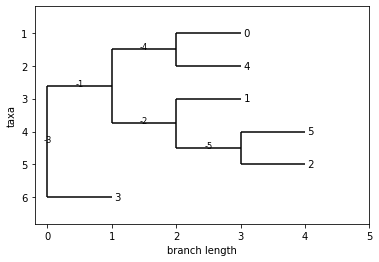

In [15]:
# treedata = "(((A,B),(C,(D,E))),F);"
treedata = "(((0,4)-4,(1,(5,2)-5)-2)-1,3)-3;"
# treedata = "(A,(B,C),(D,E));"
handle = StringIO(treedata)
tree = Phylo.read(handle, "newick")

# tree.ladderize()   # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

In [16]:
print(tree)

Tree(rooted=False, weight=1.0)
    Clade(confidence=-3.0)
        Clade(confidence=-1.0)
            Clade(confidence=-4.0)
                Clade(name='0')
                Clade(name='4')
            Clade(confidence=-2.0)
                Clade(name='1')
                Clade(confidence=-5.0)
                    Clade(name='5')
                    Clade(name='2')
        Clade(name='3')


---

# Implement Decoding Method

In [17]:
def post_order_traversal(current_node):
#     print(current_node.data)
    if current_node.left != None:
        left_newick_string = post_order_traversal(current_node.left)
    if current_node.right != None:
        right_newick_string = post_order_traversal(current_node.right)

    if current_node.left == None and current_node.right == None:     
#         # This node is the terminal vertex
        return str(current_node.data)

    if current_node.left != None and current_node.right != None:
        newick_string = '(' + left_newick_string + ',' + right_newick_string + ')' + str(current_node.data)
    return newick_string

In [18]:
def Bandelt_Decode(Bandelt_Encode_list):
    BANDELT_NUM = len(Bandelt_Encode_list)
    # Initial with three nodes
    root_node = Bandelt_Node(sys.maxsize)
    node_1 = Bandelt_Node(1)
    node_neg_1 = Bandelt_Node(-1)
    node_0 = Bandelt_Node(0)
    # Create links between initial three nodes
    root_node.left = node_neg_1
    node_neg_1.parent = root_node
    node_neg_1.left = node_0
    node_neg_1.right = node_1
    node_1.parent = node_neg_1
    node_0.parent = node_neg_1
    
    for i in range(1, BANDELT_NUM):
        added_node_val = -(i+1)
#         print('Node going to be added: ', added_node_val)
#         print('Need to find: ', Bandelt_Encode_list[i], ' node')

        added_node_neg = Bandelt_Node(added_node_val)
        added_node_pos = Bandelt_Node(-added_node_val)

        target_node = root_node.find_node(Bandelt_Encode_list[i])

        # If target node is the left child 
        if target_node.parent.left == target_node:
            target_node.parent.left = added_node_neg
            added_node_neg.parent = target_node.parent
            added_node_neg.left = target_node
            target_node.parent = added_node_neg

            added_node_neg.right = added_node_pos
            added_node_pos.parent = added_node_neg

        # If target node is the right child
        if target_node.parent.right == target_node:
            target_node.parent.right = added_node_neg
            added_node_neg.parent = target_node.parent
            added_node_neg.right = target_node
            target_node.parent = added_node_neg

            added_node_neg.left = added_node_pos
            added_node_pos.parent = added_node_neg
    decode_tree = post_order_traversal(root_node.left)
    decode_tree_newick = decode_tree + ';'
    return (root_node, decode_tree_newick)

### First Tree Decode Example

In [19]:
first_tree_decode, first_Bandelt_encode = Bandelt_Decode(first_Bandelt_encode)

In [20]:
first_Bandelt_encode

'((((0,((8,9)-9,(7,3)-7)-8)-3,(5,(6,4)-6)-5)-4,2)-2,1)-1;'

In [21]:
first_tree_encode.print_subtree()

9223372036854775807
___ -1
______ 1
______ -2
_________ 2
_________ -4
____________ -5
_______________ -6
__________________ 6
__________________ 4
_______________ 5
____________ -3
_______________ 0
_______________ -8
__________________ -7
_____________________ 7
_____________________ 3
__________________ -9
_____________________ 8
_____________________ 9


In [22]:
first_tree_decode.print_subtree()

9223372036854775807
___ -1
______ -2
_________ -4
____________ -3
_______________ 0
_______________ -8
__________________ -9
_____________________ 8
_____________________ 9
__________________ -7
_____________________ 7
_____________________ 3
____________ -5
_______________ 5
_______________ -6
__________________ 6
__________________ 4
_________ 2
______ 1


In [23]:
first_tree_encode.compare_subtree(first_tree_decode)

True

### Second Tree Decode Example

In [24]:
second_tree_decode, second_Bandelt_encode = Bandelt_Decode(second_Bandelt_encode)

In [25]:
second_Bandelt_encode

'(((0,4)-4,((2,5)-5,1)-2)-1,3)-3;'

In [26]:
second_tree_encode.print_subtree()

9223372036854775807
___ -3
______ -1
_________ -4
____________ 0
____________ 4
_________ -2
____________ 1
____________ -5
_______________ 5
_______________ 2
______ 3


In [27]:
second_tree_decode.print_subtree()

9223372036854775807
___ -3
______ -1
_________ -4
____________ 0
____________ 4
_________ -2
____________ -5
_______________ 2
_______________ 5
____________ 1
______ 3


In [28]:
second_tree_encode.compare_subtree(second_tree_decode)

True

In [29]:
# def bread_first_search(root_node):
#     visited_nodes.append(root_node.data)
#     queue.append(root_node)
    
#     while queue:
#         current_node = queue.pop(0)
#         if current_node != None:
#             print (current_node.data, end = " ") 
#         if current_node.left != None:
#             if current_node.left.data not in visited_nodes:
#                 visited_nodes.append(current_node.left.data)
#                 queue.append(current_node.left)
#         if current_node.right != None:
#             if current_node.right.data not in visited_nodes:
#                 visited_nodes.append(current_node.right.data)
#                 queue.append(current_node.right)    

In [30]:
# def depth_first_search(root_node):
#     visited_nodes = []
#     stack = []
    
#     visited_nodes.append(root_node.data)
#     stack.append(root_node)
    
#     while stack:
#         current_node = stack.pop(len(stack)-1)
        
#         if current_node != None:
#             print (current_node.data, end = " ") 
#         if current_node.left != None:
#             if current_node.left.data not in visited_nodes:
#                 visited_nodes.append(current_node.left.data)
#                 stack.append(current_node.left)
#         if current_node.right != None:
#             if current_node.right.data not in visited_nodes:
#                 visited_nodes.append(current_node.right.data)
#                 stack.append(current_node.right)    

## More Encoding / Decoding Examples

In [31]:
third_tree_encode, third_Bandelt_encode = Bandelt_Encode("(((((0,1)-1,2)-2,3)-3,4)-4,((((6,5)-6,7)-7,8)-8,9)-9)-5;")

In [32]:
third_tree_encode.print_subtree()

9223372036854775807
___ -5
______ -4
_________ -3
____________ -2
_______________ -1
__________________ 0
__________________ 1
_______________ 2
____________ 3
_________ 4
______ -9
_________ -8
____________ -7
_______________ -6
__________________ 6
__________________ 5
_______________ 7
____________ 8
_________ 9


In [33]:
third_Bandelt_encode

[0, -1, -2, -3, -4, 5, -6, -7, -8]

In [34]:
third_tree_decode, third_Bandelt_Decode = Bandelt_Decode(third_Bandelt_encode)

In [35]:
third_Bandelt_Decode

'(((((0,1)-1,2)-2,3)-3,4)-4,(9,(8,(7,(6,5)-6)-7)-8)-9)-5;'

In [36]:
third_tree_decode.print_subtree()

9223372036854775807
___ -5
______ -4
_________ -3
____________ -2
_______________ -1
__________________ 0
__________________ 1
_______________ 2
____________ 3
_________ 4
______ -9
_________ 9
_________ -8
____________ 8
____________ -7
_______________ 7
_______________ -6
__________________ 6
__________________ 5


In [37]:
third_tree_encode.compare_subtree(third_tree_decode)

True